# Entrenamiento: Modelo Cloud Binary Mask
Notebook para el entrenamiento del modelo "Cloud Binary Mask", cuyo trabajo es determinar cuando los pixeles representan nube.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [2]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [3]:
trainconfig.preparar_dataset()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Importamos modelo

In [5]:
modelo = modelos.Modelo_CBM()
modelo.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 37, 37, 5)]       0         
                                                                 
 dense_3 (Dense)             (None, 37, 37, 10)        60        
                                                                 
 dense_4 (Dense)             (None, 37, 37, 10)        110       
                                                                 
 dense_5 (Dense)             (None, 37, 37, 10)        110       
                                                                 
 batch_normalization_3 (Batc  (None, 37, 37, 10)       40        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 15)        1365      
                                                           

### Preparando secuenciador

In [9]:
def callback_y(y):
    """
    Separa en segmentos al cloud binary mask.
    De esta manera trasnformamos el problema
    en una tarea de segmentación de imágen.
    """
    resolucion = y.shape[1]
    y = np.reshape(y,(-1,resolucion,resolucion))
    mask_nubes = y == 1
    mask_clear = y == 0
    y = np.stack([mask_nubes,mask_clear],axis=3)
    return y

# Callback para igualar las clases
class_weights = list(modelo.class_weight.values())
class_weights = tf.constant(class_weights)
class_weights = class_weights/tf.reduce_sum(class_weights)
def add_sample_weights(image, label):
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

# ------------------------------------------------------------------

lista_keys_X = ["4","6","14","16","Altura"]
lista_keys_y = ["CM"]

secuenciador_train = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TRAIN,
    callback_sample_weight=None,
    callback_y=callback_y,
)

secuenciador_test = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TEST,
    callback_sample_weight=None,
    callback_y=callback_y,
)

## Entrenamos modelo

In [56]:
epochs = 40
learning_rate = 0.0001

modelo.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

try:
    history = modelo.fit(
        secuenciador_train,
        epochs=epochs,
        validation_data=secuenciador_test,
        shuffle=False,
        verbose=1,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento CBM",weight="bold")
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val accuracy")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.grid()

Epoch 1/40


InvalidArgumentError:  Can not squeeze dim[3], expected a dimension of 1, got 2
	 [[{{node remove_squeezable_dimensions/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_bool_Squeeze}}]] [Op:__inference_train_function_274008]

## Inspección visual resultados

Text(0.5, 1.0, 'y inferencia round')

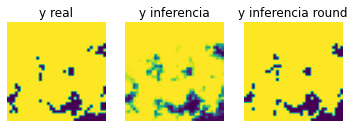

In [50]:
batch = 0
index = 33
modelo.train = False

x_prueba , y_real = secuenciador_test.__getitem__(batch)

y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_prueba).numpy()
y_inferencia = y_inferencia[index]
y_inferencia_round = np.round(y_inferencia)

fig,ax = plt.subplots(1,3)
for i in range(3): ax[i].axis("off")

ax[0].imshow(y_real,vmin=0,vmax=1)
ax[0].set_title("y real")
ax[1].imshow(y_inferencia,vmin=0,vmax=1)
ax[1].set_title("y inferencia")
ax[2].imshow(y_inferencia_round,vmin=0,vmax=1)
ax[2].set_title("y inferencia round")

### Guardamos pesos

In [51]:
# Guardar pesos
save = False

if save:
    modelo.save_weights(f"{trainconfig.DIR_PESOS}/CBM/pesos.tf",save_format="tf")
    print(f"Pesos guardados en {trainconfig.DIR_PESOS}/CBM/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//CBM/pesos.tf


### Illustraciones

In [10]:
# Cargamos pesos
modelo = modelos.Modelo_CBM()
modelo.load_weights(f"{trainconfig.DIR_PESOS}/CBM/pesos.tf")
modelo.train = False

Text(0.5, 1.0, 'Cloud Binary Mask Inferido')

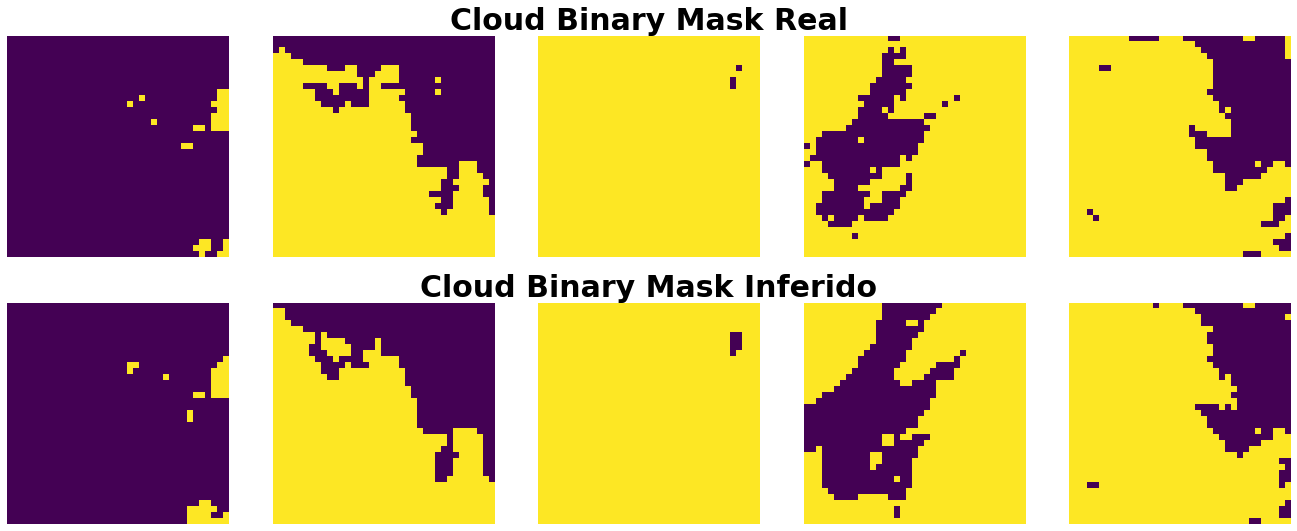

In [18]:
#-----------------------
# Ejemplos de inferencia
#-----------------------
batch = 7

x_real , y_real = secuenciador_test.__getitem__(batch)

# Caracterizamos
lon_batch = x_real.shape[0]
num_ejemplos = 5

# Obtenemos index radom 
index = np.random.randint(0,lon_batch,num_ejemplos)

# Hacemos inferencia
x_real = x_real[index] 
y_real = y_real[index,:,:,0]
y_inferencia = np.round(modelo(x_real).numpy())

fig,ax = plt.subplots(2,num_ejemplos,figsize=(4*num_ejemplos + 3,4*2 + 1))
for i in range(num_ejemplos):
    ax[0,i].axis("off")
    ax[1,i].axis("off")
    
    ax[0,i].imshow(y_real[i],vmin=0,vmax=1)
    ax[1,i].imshow(y_inferencia[i],vmin=0,vmax=1)
    
ax[0,2].set_title("Cloud Binary Mask Real",weight="bold",fontsize=30)
ax[1,2].set_title("Cloud Binary Mask Inferido",weight="bold",fontsize=30)

Text(0.5, 1.0, 'Output\nCloud Binary Mask')

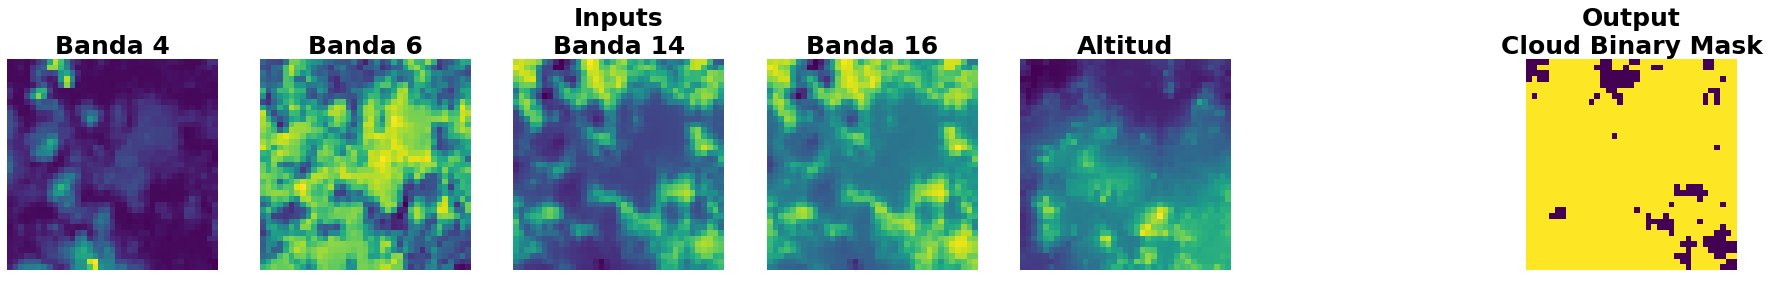

In [47]:
#------------------------
# Ejemplo input -> Output
#------------------------

batch = 0
index = 17

x_real , y_real = secuenciador_test.__getitem__(batch)
y_inferencia = np.round(modelo(x_real).numpy())

titulos_input = [
    "Banda 4",
    "Banda 6",
    "Inputs\nBanda 14",
    "Banda 16",
    "Altitud",    
]

fig,ax = plt.subplots(1,7,figsize=(4*7+3,5))

# Configuraciones generales
for i in range(7):
    ax[i].axis("off")
    
# Ploteamos inputs
for i in range(5):
    ax[i].imshow(x_real[index,:,:,i])
    ax[i].set_title(titulos_input[i],weight="bold",fontsize=25)
    
# Ploteamos Output
ax[6].imshow(y_inferencia[index,:,:])
ax[6].set_title("Output\nCloud Binary Mask",weight="bold",fontsize=25)